# Injection Program

**This is an archived notebook. It has been combined with other notebooks to form what is now the "[MAIN] phase comparison" file**

* Serves as a communication platform between
    * Teensy -- odorant valves
    * Spectrometer
    * SQL database
* Allows user to control spectrometer settings, and experiment recipe procedure

Import Modules

In [1]:
from seabreeze.spectrometers import Spectrometer
from matplotlib import pyplot as plt
import time
import numpy as np
import serial
import sys
import numpy as np
import csv
from scan_functions import *
import pandas as pd
import sqlite3
import datetime

Import Spectrometer

In [3]:
spec = Spectrometer.from_first_available()

Set Integration Time

In [4]:
time_in_ms = int(input("Set integration time (in ms): "))*10**3
spec.integration_time_micros(time_in_ms) # Sets integration time

Set integration time (in ms): 14


Set recipe

In [5]:
odorant_time = input("Please input the cycle times in seconds: ")
delay_time = int(input("How many scans per second?: "))

odorant_time = csv_to_time(odorant_time)

invalid_input = True

while invalid_input:
    wrong = False
    clean_time = input("Please input the cleaning times in seconds ({} or a single value): ".format(len(odorant_time)))

    clean_time = csv_to_time(clean_time)

    if len(clean_time) == 1: 
        clean_time = [clean_time[0] for i in range(len(odorant_time))]
    elif len(clean_time) != len(odorant_time): 
        print("Try again. \n")
        wrong = True
        
    invalid_input = False + wrong
    


Please input the cycle times in seconds: 30 30 30
How many scans per second?: 10
Please input the cleaning times in seconds (3 or a single value): 600 60 60


Run the Experiment

Which port number is is the teensy?: 4
Experiment Name: 14
What compound are you testing?: ipa
What procedure are you performing?: testing

------------------------------
Done Captures!
Do you have any comments about the experiment?: None


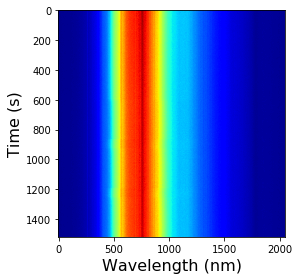

In [9]:
port = input("Which port number is is the teensy?: ").strip()

# ======================= WRITING TO SQL DATABASE =======================
conn = sqlite3.connect('Database/Sniffing-Sensor.db') # connect to the database
c = conn.cursor() # Creates a cursor to interact with database

# Experiment Name - Integer ID
exp_name = "Default"
c.execute("SELECT ExperimentID FROM Experiments")
data = c.fetchall()
if data == []: 
    exp_name = 1
else:
    exp_name = data[-1][0] + 1
print("Experiment Name: {}".format(exp_name))

# Timestamp
timestamp = str(datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S'))

# Compound name coded into its OdorID from the database
compound = input("What compound are you testing?: ").strip().upper()
temp = c.execute("SELECT OdorID FROM Odors WHERE Name='%s'" %str(compound))
OdorID = c.fetchall()[0][0]


# Procedure name coded into its ProcedureID from the database
procedure = input("What procedure are you performing?: ").strip().capitalize()
temp = c.execute("SELECT ProcedureID FROM Procedures WHERE Name='%s'" %str(procedure))
ProcedureID = c.fetchall()[0][0]

# Creates a PNG and CSV File pointing to the location of the files
PNG = "../Scan CSV Files/CSV/{}.png".format(exp_name)
CSV = "../Scan CSV Files/PNG/{}.png".format(exp_name)


# ======================= WRITING TO CSV File =======================

df = pd.DataFrame()
df["Wavelengths"] = spec.wavelengths()
df.set_index("Wavelengths")
   
# ============================== RECIPE ==============================
ser = serial.Serial("COM{}".format(port), 9600) # Opening serial port to communicate with teensy

intensities = [spec.intensities()] # empty list to be populated with intensity values from spec
elapse = [0] #empty list to be populated with time values


for i in range(len(odorant_time)): 
    nitro_arg = [clean_time[i], ser, intensities, spec, elapse]
    Nitrogen(*nitro_arg)
    
    odorant_arg = [odorant_time[i], ser, intensities, spec, delay_time, elapse]
    IPA(*odorant_arg) # Change the function based on what odorant you are testing
    
for i in range(len(elapse)):
    df["{}".format(round(elapse[i],2))] = intensities[i] # Write to the i'th column the intensities

sys.stdout.write("\n{}\nDone Captures!\n".format('-'*30))
    
# ========================== WRITING TO FILES ==========================
df.to_csv("../Scan CSV Files/{}.csv".format(exp_name)) # Writing to the CSV file

plot_river(np.array(intensities),plt, np) # Plotting river plot

plt.savefig("../Scan CSV Files/PNG/{}.png".format(exp_name)) # Save figure to file


Notes = input("Do you have any comments about the experiment?: ")
Notes += "\nOdorant Times: {}\nClean Times: {}\n".format(", ".join([str(i) for i in clean_time]),
                                                         ", ".join([str(i) for i in odorant_time]))

c.execute("""INSERT INTO Experiments (Timestamp, OdorID, ProcedureID, PNG, CSV, Notes)
             VALUES (?, ?, ?, ?, ?, ?)""",
             (timestamp, OdorID, ProcedureID, PNG, CSV, Notes))


# ========================== CLOSE CONNECTIONS ==========================
conn.commit() # Save values
ser.close() # Closing serial
c.close() # Close cursor 
conn.close() # Close connection to save memory